In [1]:
import os
from openai import OpenAI
import time
import random


In [ ]:
%env GROQ_API_KEY=XXX


In [3]:
groq_client = OpenAI(
    api_key=os.environ.get("GROQ_API_KEY"),
    base_url="https://api.groq.com/openai/v1"
)

In [4]:
def test_prompt_groq(prompt, suppress=False, model='meta-llama/llama-4-scout-17b-16e-instruct', retries=10, **kwargs):
    """A simple function to take in a prompt and run it through a given non-chat model with retries."""

    for attempt in range(retries):
        try:
            chat_completion = groq_client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=model,
                **kwargs
            )
            answer = chat_completion.choices[0].message.content
            if not suppress:
                print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE (from {model})\n------\n{answer}')
            return answer
        except Exception as e:
            wait_time = 2 ** attempt + random.uniform(0, 1)  # Exponential backoff
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {wait_time:.2f} seconds...")
            time.sleep(wait_time)

    raise RuntimeError(f"Failed after {retries} retries.")


In [5]:
test_prompt_groq('1+1=', model='meta-llama/llama-4-scout-17b-16e-instruct')

PROMPT:
------
1+1=
------
RESPONSE (from meta-llama/llama-4-scout-17b-16e-instruct)
------
The answer to that simple math question is:

2


'The answer to that simple math question is:\n\n2'

# Dynamic k shot using embeddings WITH MathQA

In [6]:
def is_num(x):
    try:
        return float(x) != None
    except:
        return False
is_num(1), is_num('true')

(True, False)

In [7]:
from datasets import load_dataset

dataset = load_dataset("math_qa")
dataset

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 29837
    })
    test: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 2985
    })
    validation: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 4475
    })
})

In [8]:
print(dataset['train']['Problem'][0])


the banker ' s gain of a certain sum due 3 years hence at 10 % per annum is rs . 36 . what is the present worth ?


In [9]:
dataset = dataset.map(
    lambda x: {
        'question': x['Problem'],
        'response': x['Rationale'].split('answer ')[0],
        'answer': x['options'].split(f'{x["correct"]} ) ')[-1].split(' ')[0]
    }
)
dataset = dataset.filter(lambda x: is_num(x['answer']))
dataset

DatasetDict({
    train: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 26318
    })
    test: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 2667
    })
    validation: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 3983
    })
})

In [10]:
dataset['test'][0]

{'Problem': 'a shopkeeper sold an article offering a discount of 5 % and earned a profit of 31.1 % . what would have been the percentage of profit earned if no discount had been offered ?',
 'Rationale': '"giving no discount to customer implies selling the product on printed price . suppose the cost price of the article is 100 . then printed price = 100 ã — ( 100 + 31.1 ) / ( 100 â ˆ ’ 5 ) = 138 hence , required % profit = 138 â € “ 100 = 38 % answer a"',
 'options': 'a ) 38 , b ) 27.675 , c ) 30 , d ) data inadequate , e ) none of these',
 'correct': 'a',
 'annotated_formula': 'subtract(divide(multiply(add(const_100, 31.1), const_100), subtract(const_100, 5)), const_100)',
 'linear_formula': 'add(n1,const_100)|subtract(const_100,n0)|multiply(#0,const_100)|divide(#2,#1)|subtract(#3,const_100)|',
 'category': 'gain',
 'question': 'a shopkeeper sold an article offering a discount of 5 % and earned a profit of 31.1 % . what would have been the percentage of profit earned if no discount ha

In [11]:
print(dataset['train']['question'][0])
print()
print(dataset['train']['response'][0])
print()
print(dataset['train']['answer'][0])

average age of students of an adult school is 40 years . 120 new students whose average age is 32 years joined the school . as a result the average age is decreased by 4 years . find the number of students of the school after joining of the new students .

"explanation : let the original no . of students be x . according to situation , 40 x + 120 * 32 = ( x + 120 ) 36 ⇒ x = 120 so , required no . of students after joining the new students = x + 120 = 240 . 

240


In [12]:
dataset = dataset.filter(lambda x: float(x['answer']) > 10000)

In [13]:
def format_k_shot(examples, cot=True):
    if cot:
        return '\n###\n'.join(
            [f'Question: {e["question"]}\nReasoning: {e["response"]}\nAnswer: {e["answer"]}' for e in examples]
        )
    else:
        return '\n###\n'.join(
            [f'Question: {e["question"]}\nAnswer: {e["answer"]}' for e in examples]
        )

In [14]:
unanswered_example = dataset['test'][0]

PROMPT = f"""Answer the question in the following format:

{format_k_shot(list(dataset['train'])[:3])}
###
Question: {unanswered_example["question"]}
Reasoning:""".strip()

print(PROMPT)

Answer the question in the following format:

Question: if the annual increase in the population of a town is 10 % and the present number of people is 10000 , what will the population be in 2 years ?
Reasoning: "the required population is = 10000 ( 1 + 10 / 100 ) ^ 2 = 10000 * 11 / 10 * 11 / 10 = 12100 
Answer: 12100
###
Question: a , b and c started a partnership business by investing rs . 12000 , rs . 16000 , rs . 20000 respectively . at the end of the year , the profit were distributed among them . if c ' s share of profit is 36000 , what is the total profit ?
Reasoning: "a : b : c = 12000 : 16000 : 20000 = 3 : 4 : 5 let total profit = p then p ã — 5 / 12 = 36000 p = ( 36000 ã — 12 ) / 5 = 86400 
Answer: 86400
###
Question: sonika deposited rs . 8000 which amounted to rs . 11200 after 3 years at simple interest . had the interest been 2 % more . she would get how much ?
Reasoning: "( 8000 * 3 * 2 ) / 100 = 480 11200 - - - - - - - - 11680 
Answer: 11680
###
Question: in an election b

In [15]:
test_prompt_groq(
    PROMPT,
    model='meta-llama/llama-4-scout-17b-16e-instruct')

PROMPT:
------
Answer the question in the following format:

Question: if the annual increase in the population of a town is 10 % and the present number of people is 10000 , what will the population be in 2 years ?
Reasoning: "the required population is = 10000 ( 1 + 10 / 100 ) ^ 2 = 10000 * 11 / 10 * 11 / 10 = 12100 
Answer: 12100
###
Question: a , b and c started a partnership business by investing rs . 12000 , rs . 16000 , rs . 20000 respectively . at the end of the year , the profit were distributed among them . if c ' s share of profit is 36000 , what is the total profit ?
Reasoning: "a : b : c = 12000 : 16000 : 20000 = 3 : 4 : 5 let total profit = p then p ã — 5 / 12 = 36000 p = ( 36000 ã — 12 ) / 5 = 86400 
Answer: 86400
###
Question: sonika deposited rs . 8000 which amounted to rs . 11200 after 3 years at simple interest . had the interest been 2 % more . she would get how much ?
Reasoning: "( 8000 * 3 * 2 ) / 100 = 480 11200 - - - - - - - - 11680 
Answer: 11680
###
Question: i

'It seems like you provided several questions and their solutions in a specific format. I\'ll be happy to help you with the last question, which seems to be incomplete.\n\n\nHowever, I will provide the solution to the last question based on the given format:\n\n\nQuestion: in an election between two candidates , the winner has a margin of10 % of the votes polled . if4000 people change their mind and vote for the loser , the loser would have won by a margin of10 % of the votes polled . find the total number of votes polled in the election ?\n\nLet\'s assume the total votes polled is x.\n\nThe winner\'s votes = 0.55x (55% of the total votes, assuming)\nThe loser\'s votes = 0.45x (45% of the total votes, assuming)\n\nThe winner\'s margin = 0.1x (10% of the total votes)\n\nIf 4000 people change their mind and vote for the loser:\nThe winner\'s votes = 0.55x - 4000\nThe loser\'s votes = 0.45x + 4000\n\nThe loser\'s margin = 0.1x (10% of the total votes)\n\nWe can set up an equation:\n\n(0.4

In [16]:
test_prompt_groq(
    PROMPT,
    model='meta-llama/llama-4-scout-17b-16e-instruct')

PROMPT:
------
Answer the question in the following format:

Question: if the annual increase in the population of a town is 10 % and the present number of people is 10000 , what will the population be in 2 years ?
Reasoning: "the required population is = 10000 ( 1 + 10 / 100 ) ^ 2 = 10000 * 11 / 10 * 11 / 10 = 12100 
Answer: 12100
###
Question: a , b and c started a partnership business by investing rs . 12000 , rs . 16000 , rs . 20000 respectively . at the end of the year , the profit were distributed among them . if c ' s share of profit is 36000 , what is the total profit ?
Reasoning: "a : b : c = 12000 : 16000 : 20000 = 3 : 4 : 5 let total profit = p then p ã — 5 / 12 = 36000 p = ( 36000 ã — 12 ) / 5 = 86400 
Answer: 86400
###
Question: sonika deposited rs . 8000 which amounted to rs . 11200 after 3 years at simple interest . had the interest been 2 % more . she would get how much ?
Reasoning: "( 8000 * 3 * 2 ) / 100 = 480 11200 - - - - - - - - 11680 
Answer: 11680
###
Question: i

"It seems like you provided several questions and their solutions in a specific format. I'll be happy to help you with the last question.\n\n\nQuestion: in an election between two candidates , the winner has a margin of10 % of the votes polled . if4000 people change their mind and vote for the loser , the loser would have won by a margin of10 % of the votes polled . find the total number of votes polled in the election ?\n\nLet's denote the total number of votes polled as x.\n\n\nLet the winner's votes be W and the loser's votes be L.\n\n\nInitially, the winner has a margin of 10% of the votes polled:\nW - L = 0.1x\n\n\nIf 4000 people change their mind and vote for the loser:\nW - 4000 - (L + 4000) = -0.1(x)\n\n\nSimplifying:\nW - L - 8000 = -0.1x\n\n\nWe already know that:\nW - L = 0.1x\n\n\nSubstituting:\n0.1x - 8000 = -0.1x\n\n\nSolving for x:\n0.2x = 8000\n\n\nx = 8000 / 0.2\nx = 40000\n\n\nReasoning: Hence, we've calculated the total votes.\n\n\nAnswer: 40000"

In [17]:
from sentence_transformers import SentenceTransformer

emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

docs = dataset['train']['question']
doc_emb = emb_model.encode(docs, batch_size=32, show_progress_bar=True)

doc_emb.shape  #  == (n, 768)


/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

(690, 768)

In [18]:
from random import sample
from sentence_transformers import util

query = dataset['test']['question'][0]
print(query)


in an election between two candidates , the winner has a margin of 10 % of the votes polled . if 4000 people change their mind and vote for the loser , the loser would have won by a margin of 10 % of the votes polled . find the total number of votes polled in the election ?


In [19]:
MODELS = [
    "meta-llama/llama-4-scout-17b-16e-instruct",
    # "meta-llama/llama-4-maverick-17b-128e-instruct"
]


In [20]:
retries = 5

In [21]:
import re
import numpy as np
import random

def extract_num(string):
    pattern = r'[\d,]+'
    match = re.search(pattern, string)
    if match:
        number_str = match.group()
        try:
            number = float(number_str.replace(',', ''))
            return number
        except:
            return -1
    return -1

def test_k_shot(
    k, datapoint, verbose=False, how='closest', cot=True, options=MODELS
):
    results = {}

    prompt_elements = ['Answer the question in the following format:']
    if cot:
        prompt_elements.append('Question: (a question)\nReasoning: (thinking through step by step on how to solve the problem)\nAnswer: (the final answer as a number)')
    else:
        prompt_elements.append('Question: (a question)\nAnswer: (the final answer as a number)')

    if k > 0:
        if how == 'closest':
            query_emb = emb_model.encode(str(datapoint['question']))
            scores = util.dot_score(query_emb, doc_emb)[0].cpu().tolist()
            # Retrieve the corresponding examples from the dataset
            examples = [dataset['train'][int(_)] for _ in np.argsort(scores)[-k:][::-1]]
        else:
            examples = random.sample(list(dataset['train']), k)

        prompt_elements.append(format_k_shot(examples, cot=cot))

    if cot:
        prompt_elements.append(f'Question: {datapoint["question"]}\nReasoning:')
    else:
        prompt_elements.append(f'Question: {datapoint["question"]}\nAnswer:')


    PROMPT = '\n\n'.join(prompt_elements)

    if verbose:
        print(f'PROMPT\n-----\n{PROMPT}\n-----')


    for model_option in options:
        response = test_prompt_groq(PROMPT, model=model_option, temperature=0, suppress=True, retries=retries)
        results[model_option] = {'num': extract_num(response.split('Answer: ')[-1]), 'response': response, 'question': datapoint['question']}

    results['answer'] = extract_num(datapoint['answer'])

    return results

In [22]:
datapoint = dataset['test'][1]
test_k_shot(0, datapoint, verbose=True, cot=False)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Answer: (the final answer as a number)

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Answer:
-----


{'meta-llama/llama-4-scout-17b-16e-instruct': {'num': 11888.0,
  'response': '## Step 1: Identify the digits to be used and the conditions.\nThe digits to be used are 3, 4, and 5, and repetition is allowed.\n\n## 2. Determine the number of 3-digit integers that can be formed.\nSince repetition is allowed and we have 3 choices for each digit, there are $3 \\times 3 \\times 3 = 3^3 = 27$ possible 3-digit integers.\n\n## 3: List all possible 3-digit integers or understand the pattern.\nThe possible integers are formed by combining 3, 4, and 5 in all possible ways. This includes 333, 334, 335, 343, 344, 345, 353, 354, 355, 433, 434, 435, 443, 444, 445, 453, 454, 455, 533, 534, 535, 543, 544, 545, 553, 554, 555.\n\n## 4: Calculate the sum of all the 3-digit integers.\nTo find the sum, notice that each digit (3, 4, 5) appears in each place value (hundreds, tens, ones) an equal number of times due to the permutations being exhaustive and evenly distributed.\n\n## 5: Calculate the number of ti

In [23]:
test_k_shot(0, datapoint, verbose=True, cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


{'meta-llama/llama-4-scout-17b-16e-instruct': {'num': 1.0,
  'response': '## Step 1: Identify the digits to work with and the conditions.\nThe digits to work with are 3, 4, and 5, and repetition is allowed.\n\n## 2: Determine the number of 3-digit integers that can be formed.\nSince repetition is allowed and we have 3 choices for each digit, there are $3 \\times 3 \\times 3 = 3^3 = 27$ possible 3-digit integers.\n\n## 3: List out the possible 3-digit integers or understand the pattern.\nThe possible integers are formed by combining 3, 4, and 5 in various ways. This includes 333, 334, 335, 343, 344, 345, 353, 354, 355, 433, 434, 435, 443, 444, 445, 453, 454, 455, 533, 534, 535, 543, 544, 545, 553, 554, 555.\n\n## 4: Calculate the sum of all the 3-digit integers.\nTo find the sum, notice that each digit (3, 4, 5) appears in each place value (hundreds, tens, ones) an equal number of times due to the permutations being exhaustive and evenly distributed.\n\n## 5: Determine how many times ea

In [24]:
test_k_shot(1, datapoint, verbose=True, how='random', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: thomas worked in the factory @ 4550 / - per week . owner told him to give the amount after one month . then how much amount will be paid to thomas ?
Reasoning: total salary paid to thomas in one week : 4550 / - salary for one day : 4550 / 7 = 650 / - total for one month = 650 / - * 30 days = 19500 / - 
Answer: 19500

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


{'meta-llama/llama-4-scout-17b-16e-instruct': {'num': 11988.0,
  'response': 'Question: what is the sum of all 3 digit integers formed using the digits 3, 4, and 5 (repetition is allowed)\n\nReasoning: \nTo find the sum of all 3-digit integers formed using the digits 3, 4, and 5 with repetition allowed, we first need to determine how many such numbers exist. Since repetition is allowed and we have 3 choices for each digit, there are 3 * 3 * 3 = 27 such numbers.\n\nEach digit (3, 4, 5) will appear in each place value (hundreds, tens, ones) the same number of times due to the nature of permutations with repetition. \n\nThere are 27 numbers, so each digit appears in each place (ones, tens, hundreds) 27 / 3 = 9 times.\n\nThe sum for the ones place is 9 * (3 + 4 + 5) = 9 * 12 = 108.\n\nThe same logic applies to the tens and hundreds places, but the value is multiplied by 10 and 100 respectively for those places.\n\nSo, the total sum is: \n108 * 1 (for the ones place) + 108 * 10 (for the ten

In [25]:
test_k_shot(1, datapoint, verbose=True, how='closest', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 4 digit integers formed using the digits 2 , 3 , 4 and 5 ( repetition is allowed )
Reasoning: n = 4 * 4 * 4 * 4 = 256 < x > = ( 5555 + 2222 ) / 2 = 3888.5 sum = number of integers x average value n * < x > = 256 * 3888.5 = 711040 
Answer: 995456

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


{'meta-llama/llama-4-scout-17b-16e-instruct': {'num': 11988.0,
  'response': "To solve this problem, let's follow the steps outlined in the reasoning format provided.\n\n## Question: \nwhat is the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed)\n\n## Reasoning:\n- First, we need to calculate the total number of 3-digit integers that can be formed using the digits 3, 4, and 5 with repetition allowed. Since there are 3 choices for each digit and we are forming 3-digit numbers, the total number of integers, n, is calculated as:\n  n = 3 * 3 * 3 = 3^3 = 27\n\n- Next, we find the average value of these numbers, <x>. The smallest 3-digit number that can be formed is 333 and the largest is 555. The average value is:\n  <x> = (555 + 333) / 2 = 888 / 2 = 444\n\n- Finally, to find the sum of all these integers, we multiply the total number of integers by the average value:\n  Sum = n * <x> = 27 * 444 = 11988\n\n## Answer: \n11988",
  'question': 'what is t

In [26]:
test_k_shot(3, datapoint, verbose=True, how='closest', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 4 digit integers formed using the digits 2 , 3 , 4 and 5 ( repetition is allowed )
Reasoning: n = 4 * 4 * 4 * 4 = 256 < x > = ( 5555 + 2222 ) / 2 = 3888.5 sum = number of integers x average value n * < x > = 256 * 3888.5 = 711040 
Answer: 995456
###
Question: find the sum of all 4 digit numbers formed using digits 1,2 , 5,6 .
Reasoning: "( n - 1 ) ! * ( 111 . . . n ) * ( sum of the digits ) = ( 4 - 1 ) ! * 1111 * ( 1 + 2 + 5 + 6 ) = 93324 
Answer: 93324
###
Question: what is the sum of all 3 digit nos formed by { 1 , 3,5 , 7,9 } with nos not repeated
Reasoning: "here 3 digit no . can be formed in 5 * 4 * 3 = 60 . thus we hv to find the sum of 60 nos . now 60 / 5 = 12 ; we hv 12 no ' s . starting with 1 , 12 no ' s . with 3,5 , 7,9 . . . . so 12 * 100 * ( 1 + 3 + 5

{'meta-llama/llama-4-scout-17b-16e-instruct': {'num': 11988.0,
  'response': "To find the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed), let's break it down:\n\n## Step 1: Determine the total number of 3-digit integers that can be formed.\nSince repetition is allowed and we have 3 choices (3, 4, or 5) for each digit, there are \\(3 \\times 3 \\times 3 = 3^3 = 27\\) possible 3-digit integers.\n\n## 2: Calculate the average value of these integers.\nThe smallest 3-digit number that can be formed is 333 and the largest is 555. The average value \\(< x >\\) of these numbers can be calculated as the average of the smallest and largest number: \\(< x > = \\frac{333 + 555}{2} = \\frac{888}{2} = 444\\).\n\n## 3: Calculate the sum of all these integers.\nThe sum of all these integers can be found by multiplying the total number of integers by the average value: \\(27 \\times 444\\).\n\n## 4: Perform the multiplication.\nSum \\(= 27 \\times 444 = 11988\\

In [27]:
t, batch_size = 5, 5  # time to wait in seconds, batch size

In [28]:
import numpy as np
import random

random.seed(42)

dataset_sample = random.sample(list(dataset['test']), 50)

In [29]:
len(dataset_sample)

50

In [30]:
dataset_sample[0]

{'Problem': 'the population of a bacteria colony doubles every day . if it was started 8 days ago with 3 bacteria and each bacteria lives for 12 days , how large is the colony today ?',
 'Rationale': '"3 ^ 8 * ( 2 ) = 13122 the answer is c"',
 'options': 'a ) 512 , b ) 768 , c ) 13122 , d ) 2048 , e ) 4096',
 'correct': 'c',
 'annotated_formula': 'subtract(power(3, add(8, const_1)), const_1)',
 'linear_formula': 'add(n0,const_1)|power(n1,#0)|subtract(#1,const_1)|',
 'category': 'physics',
 'question': 'the population of a bacteria colony doubles every day . if it was started 8 days ago with 3 bacteria and each bacteria lives for 12 days , how large is the colony today ?',
 'response': '"3 ^ 8 * ( 2 ) = 13122 the ',
 'answer': '13122'}

In [31]:
import time

In [32]:
results = {}

# Just Ask (K=0) with and without CoT

In [33]:
import concurrent.futures
from tqdm import tqdm
import time

error = 0

def test_k_shot_parallel(k, gsm, cot):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. K={k}')
        return None
k = 0
results['Just Ask (K=0 with CoT)'] = []
results['Just Ask (K=0 no CoT)'] = []

def process_batch(futures, result_list, pbar):
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            result_list.append(result)
        pbar.update(1)

with concurrent.futures.ThreadPoolExecutor() as executor:
    total_batches = (len(dataset_sample) // batch_size) * 2
    with tqdm(total=total_batches) as pbar:
        for i in range(0, len(dataset_sample), batch_size):
            time.sleep(t)
            batch_futures_with_cot = [executor.submit(test_k_shot_parallel, k, gsm, True) for gsm in dataset_sample[i:i+batch_size]]
            batch_futures_no_cot = [executor.submit(test_k_shot_parallel, k, gsm, False) for gsm in dataset_sample[i:i+batch_size]]

            process_batch(batch_futures_with_cot, results['Just Ask (K=0 with CoT)'], pbar)
            process_batch(batch_futures_no_cot, results['Just Ask (K=0 no CoT)'], pbar)

100it [01:09,  1.44it/s]                                                        


# Semantic k-shot prompting for K=1, 3, 5 with and without CoT

In [34]:
import concurrent.futures
from tqdm import tqdm

error = 0

def test_k_shot_parallel(k, gsm, cot):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, how='closest', cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. K={k}')
        return None

def process_batch(executor, batch, k, cot, result_list, description):
    futures = [executor.submit(test_k_shot_parallel, k, gsm, cot) for gsm in batch]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc=description, leave=False):
        result = future.result()
        if result is not None:
            result_list.append(result)

k_values = [1, 3]
total_batches = len(dataset_sample) // batch_size + (1 if len(dataset_sample) % batch_size != 0 else 0)

for k in tqdm(k_values, desc="K-values"):
    results[f'Semantic K={k} (with CoT)'] = []
    results[f'Semantic K={k} (no CoT)'] = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i in tqdm(range(0, len(dataset_sample), batch_size), desc=f"Batches for K={k}", total=total_batches, leave=False):
            time.sleep(t)
            batch = dataset_sample[i:i+batch_size]
            process_batch(executor, batch, k, True, results[f'Semantic K={k} (with CoT)'], f"K={k} with CoT")
            process_batch(executor, batch, k, False, results[f'Semantic K={k} (no CoT)'], f"K={k} no CoT")


ches for K=1:   0%|                                   | 0/10 [00:00<?, ?it/s]

th CoT:   0%|                                       | 0/5 [00:00<?, ?it/s]

th CoT:  20%|██████▏                        | 1/5 [00:01<00:06,  1.58s/it]

th CoT:  60%|██████████████████▌            | 3/5 [00:01<00:00,  2.22it/s]

th CoT: 100%|███████████████████████████████| 5/5 [00:01<00:00,  3.47it/s]

                                                                          

 CoT:   0%|                                         | 0/5 [00:00<?, ?it/s]

 CoT:  20%|██████▌                          | 1/5 [00:00<00:02,  1.75it/s]

 CoT:  80%|██████████████████████████▍      | 4/5 [00:01<00:00,  4.53it/s]

 CoT: 100%|█████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]

                                                                          
ches for K=1:  10%|██▋                        | 1/10 [00:08<01:14,  8.27s/it]

th CoT:   0%|                                       | 0/5 [00:00<?, ?it/s]

th CoT:

# Random k-shot prompting for K=1, 3 with and without CoT

In [35]:
import concurrent.futures
from tqdm import tqdm

error = 0

def test_k_shot_parallel(k, gsm, cot, i):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, how='random', cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. i={i}. K={k}')
        return None

def process_batch(futures, result_list, description):
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc=description, leave=False):
        result = future.result()
        if result is not None:
            result_list.append(result)

k_values = [1, 3]
total_batches = len(dataset_sample) // batch_size + (1 if len(dataset_sample) % batch_size != 0 else 0)

for k in tqdm(k_values, desc="K-values"):
    results[f'Random K={k} (with CoT)'] = []
    results[f'Random K={k} (no CoT)'] = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i in tqdm(range(0, len(dataset_sample), batch_size), desc=f"Batches for K={k}", total=total_batches, leave=False):
            time.sleep(t)
            batch = dataset_sample[i:i+batch_size]

            futures_with_cot = [executor.submit(test_k_shot_parallel, k, gsm, True, i+j) for j, gsm in enumerate(batch)]
            futures_no_cot = [executor.submit(test_k_shot_parallel, k, gsm, False, i+j) for j, gsm in enumerate(batch)]

            process_batch(futures_with_cot, results[f'Random K={k} (with CoT)'], f"K={k} with CoT")
            process_batch(futures_no_cot, results[f'Random K={k} (no CoT)'], f"K={k} no CoT")


ches for K=1:   0%|                                   | 0/10 [00:00<?, ?it/s]

th CoT:   0%|                                       | 0/5 [00:00<?, ?it/s]

th CoT:  20%|██████▏                        | 1/5 [00:01<00:05,  1.25s/it]

th CoT:  40%|████████████▍                  | 2/5 [00:01<00:01,  1.63it/s]

th CoT:  60%|██████████████████▌            | 3/5 [00:01<00:00,  2.48it/s]

                                                                          

 CoT:   0%|                                         | 0/5 [00:00<?, ?it/s]

                                                                          
ches for K=1:  10%|██▋                        | 1/10 [00:06<01:00,  6.70s/it]

th CoT:   0%|                                       | 0/5 [00:00<?, ?it/s]

th CoT:  20%|██████▏                        | 1/5 [00:01<00:04,  1.25s/it]

th CoT:  60%|██████████████████▌            | 3/5 [00:01<00:00,  2.25it/s]

th CoT:  80%|████████████████████████▊      | 4/5 [00:01<00:00,  2.97it/s]

th CoT:

In [36]:
# Open a file for writing
import json
with open('results.json', 'w') as f:
    # Write the dictionary to the file as a JSON string
    json.dump(results, f)

In [37]:
for k, values in results.items():
    print(k, len(values))

Just Ask (K=0 with CoT) 50
Just Ask (K=0 no CoT) 50
Semantic K=1 (with CoT) 50
Semantic K=1 (no CoT) 50
Semantic K=3 (with CoT) 50
Semantic K=3 (no CoT) 50
Random K=1 (with CoT) 50
Random K=1 (no CoT) 50
Random K=3 (with CoT) 50
Random K=3 (no CoT) 50


In [38]:
retry_dict = {}

for sample_i, sample in enumerate(dataset_sample):
    for experiment, experiment_results in results.items():
        for model in MODELS:
            model_needs_retry = True  # Assume retry is needed unless explicitly found

            for experiment_result in experiment_results:
                if model in experiment_result:

                    if 'question' in experiment_result[model] and experiment_result[model]['question'] == sample['question']:
                        model_needs_retry = False
                        break

            if model_needs_retry:
                if model not in retry_dict:
                    retry_dict[model] = {}
                if experiment not in retry_dict[model]:
                    retry_dict[model][experiment] = []
                retry_dict[model][experiment].append(sample_i)

print(retry_dict)


for model in retry_dict.keys():
    print({k: len(v) for k, v in retry_dict[model].items()})


{}


In [39]:
import re

for model, experiments in retry_dict.items():
    for experiment, sample_indices in experiments.items():
        cot = 'with cot' in experiment.lower()
        k_match = re.search(r'K=(\d+)', experiment)
        k = int(k_match.group(1)) if k_match else 0
        how = 'closest' if 'semantic' in experiment.lower() else 'random'

        for sample_i in sample_indices:
            sample = dataset_sample[sample_i]
            print(f"Running test_k_shot for Model={model}, Experiment={experiment}, DataPoint={sample_i}, k={k}, cot={cot}, how={how}")
            try:
                result = test_k_shot(k=k, datapoint=sample, verbose=False, cot=cot, how=how, options=[model])
                result['num'] = extract_num(result[model]['response'].split('Answer: ')[-1])
                result['answer'] = extract_num(sample['answer'])
                # Ensure the results structure is maintained
                if experiment not in results:
                    results[experiment] = []
                results[experiment].append(result)
            except Exception as e:
                print(e)


In [40]:
import json

accuracy = {}
for k, values in results.items():
    if not values:
        continue
    accuracy[k] = {v: 0 for v in values[0].keys() if v != 'answer'}
    for d in values:
        for model_name in accuracy[k].keys():
            try:
                accuracy[k][model_name] += (1 if d[model_name]['num'] == d['answer'] else 0)
            except:
                pass
    for model_name in accuracy[k].keys():
        accuracy[k][model_name] /= len(values)
print(json.dumps(accuracy, indent=2))

{
  "Just Ask (K=0 with CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.66
  },
  "Just Ask (K=0 no CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.54
  },
  "Semantic K=1 (with CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.72
  },
  "Semantic K=1 (no CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.54
  },
  "Semantic K=3 (with CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.68
  },
  "Semantic K=3 (no CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.44
  },
  "Random K=1 (with CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.68
  },
  "Random K=1 (no CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.4
  },
  "Random K=3 (with CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.66
  },
  "Random K=3 (no CoT)": {
    "meta-llama/llama-4-scout-17b-16e-instruct": 0.36
  }
}


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [42]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Define pastel colors and hatch patterns for each technique
technique_styles = {
    "Just Ask (K=0 with CoT)": ('#AEC6CF', '/'),
    "Just Ask (K=0 no CoT)": ('#77DD77', '\\'),
    "Semantic K=1 (with CoT)": ('#FFB347', '+'),
    "Semantic K=1 (no CoT)": ('#CFCFC4', 'x'),
    "Semantic K=3 (with CoT)": ('#F49AC2', 'o'),
    "Semantic K=3 (no CoT)": ('#FFD1DC', 'O'),
    "Random K=1 (with CoT)": ('#B39EB5', '.'),
    "Random K=1 (no CoT)": ('#FF6961', '*'),
    "Random K=3 (with CoT)": ('#CB99C9', '-'),
    "Random K=3 (no CoT)": ('#FDFD96', '|')
}


def plot_results(title, filter=None, cot=None, filter_labels=None, labels = MODELS):
    if filter_labels:
        labels = [l for l in MODELS if any(f in l for f in filter_labels)]
    k_values = list(accuracy.keys())
    if filter:
        k_values = [_ for _ in k_values if any(f in _ for f in filter)]
    if cot is not None:
        if cot:
            k_values = [_ for _ in k_values if 'with CoT' in _]
        else:
            k_values = [_ for _ in k_values if 'no CoT' in _]

    sorted_k_values = sorted(k_values)
    sorted_accuracy = {label: [accuracy[k][label] for k in sorted_k_values] for label in labels}

    fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better visibility

    bar_width = 0.15
    num_variants = len(sorted_k_values)

    for i, k in enumerate(sorted_k_values):
        variant_values = [sorted_accuracy[label][i] for label in labels]
        x = np.arange(len(labels)) + (i * bar_width)
        color, hatch = technique_styles[k]
        bars = ax.bar(x, variant_values, bar_width, label=k, alpha=0.8, color=color, hatch=hatch)

    ax.set_ylabel('Accuracy on test set', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(np.arange(len(labels)) + (bar_width * (num_variants - 1) / 2))
    ax.set_xticklabels(labels, fontsize=12, rotation=0)
    ax.set_ylim(0, 1.)  # Set y-limit from 0 to 0.8

    # Create custom legend
    legend_handles = [
        Patch(facecolor=technique_styles[k][0], hatch=technique_styles[k][1], label=k) for k in technique_styles.keys() if k in k_values
    ]
    ax.legend(
        handles=legend_handles, title="Legend", loc='upper center',
        bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3
    )

    plt.tight_layout()
    plt.savefig(title+'.png', dpi=1000, bbox_inches='tight')  # Save with higher DPI for better quality
    plt.show()

# Does Prompting make a Difference? YES YES YES

In [43]:
MODELS

['meta-llama/llama-4-scout-17b-16e-instruct']

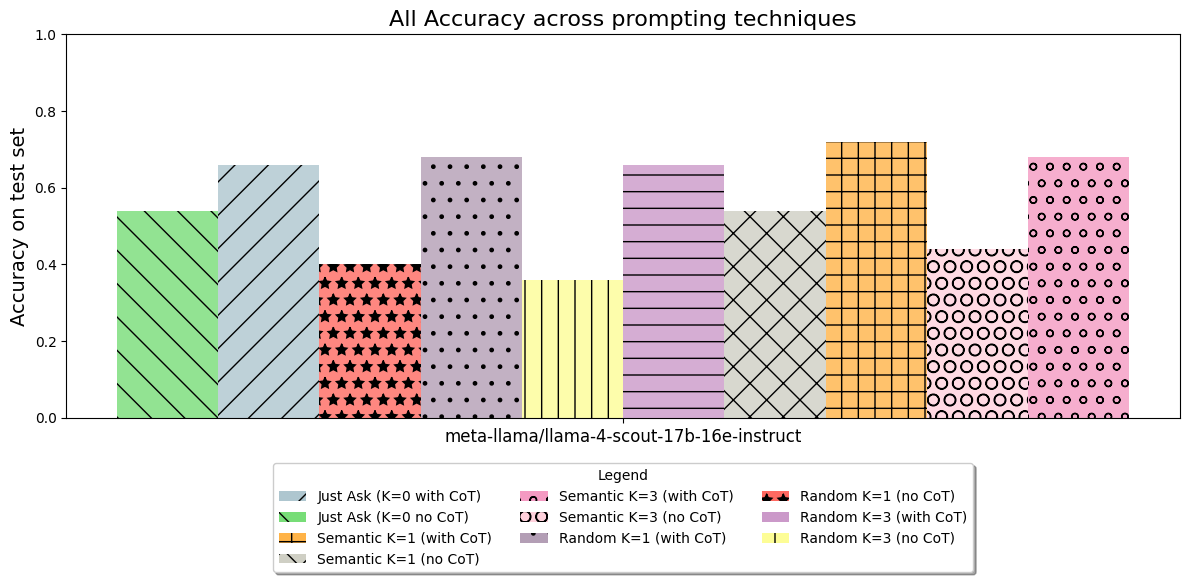

In [44]:
plot_results('All Accuracy across prompting techniques')

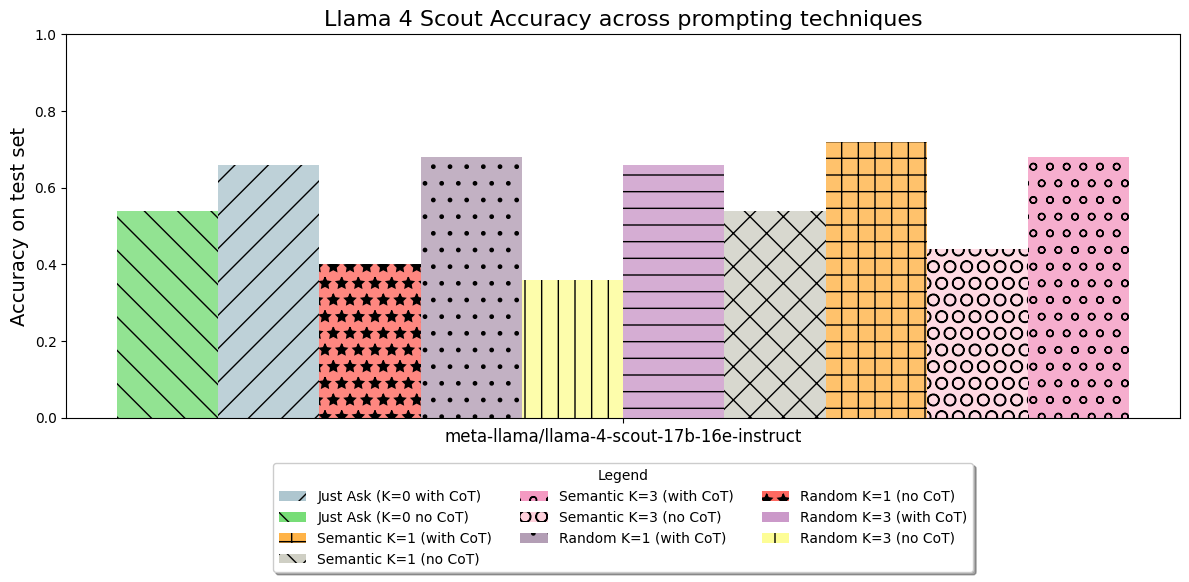

In [45]:
plot_results('Llama 4 Scout Accuracy across prompting techniques', filter_labels=['llama-4'])

In [50]:
import pandas as pd

results

{'Just Ask (K=0 with CoT)': [{'meta-llama/llama-4-scout-17b-16e-instruct': {'num': 12003.0,
    'response': 'Question: 12008 - 50 ÷ 10.00 = ?\n\nReasoning: \nTo solve this problem, we need to follow the order of operations, which is often remembered by the acronym PEMDAS: Parentheses, Exponents, Multiplication and Division (from left to right), Addition and Subtraction (from left to right).\n\nGiven the expression: 12008 - 50 ÷ 10.00\n\n1. First, we perform the division: 50 ÷ 10.00 = 5\n2. Then, we perform the subtraction: 12008 - 5 = 12003\n\nAnswer: 12003',
    'question': '12008 - 50 ÷ 10.00 = ?'},
   'answer': 12003.0},
  {'meta-llama/llama-4-scout-17b-16e-instruct': {'num': 6336000.0,
    'response': "To convert 100 miles into inches, let's break down the conversion step by step.\n\n1. **Miles to Feet**: First, we know that 1 mile = 5280 feet. So, 100 miles = 100 * 5280 feet = 528,000 feet.\n\n2. **Feet to Inches**: Since 1 foot = 12 inches, we can convert 528,000 feet into inches